In [1]:
%load_ext autoreload
%autoreload 2

In [80]:
import torch
from datasets import load_dataset
from mini_yolov3.dataset import SVNHDataset, collate_fn
from mini_yolov3.inference import non_maximum_suppression
from mini_yolov3.utils import coco_to_xyxy, draw_bounding_boxes, draw_grid, box_iou
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from mini_yolov3.loss import YOLOLoss, build_targets
from mini_yolov3.model_output import to_bbox_pred

In [3]:
dataset = SVNHDataset(split="train", image_size=64, normalize=True, type="tensor", bbox_format="xywh")

In [4]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [5]:
anchors = torch.Tensor([[0.2, 0.8]])

In [6]:
for x in dataloader:
    bbox = x["bbox"]
    labels = x["labels"]

    print(bbox)

    target = build_targets(bbox, grid_size=2, labels=labels, anchors=anchors, bbox_format="xywh")

    break

[tensor([[0.4533, 0.4565, 0.1963, 0.8696],
        [0.6075, 0.5000, 0.1495, 0.8696]])]


In [8]:
target[0, :, 0, 0], target[0, :, 1, 1]

(tensor([-0.1875, -0.1744, -0.0189,  0.0834,  1.0000,  4.0000]),
 tensor([ -2.1168, -18.4207,  -0.2908,   0.0834,   1.0000,   6.0000]))

In [9]:
item = dataset[0]
image = item["image"]

torch.Size([2, 4])


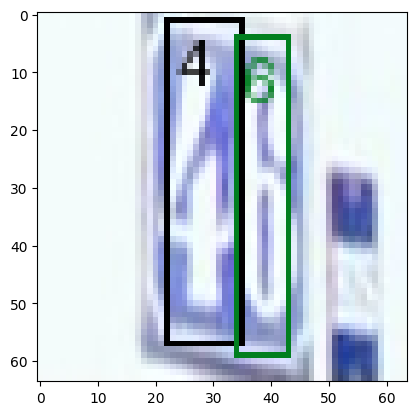

In [10]:
plt.imshow(draw_bounding_boxes(image, bbox[0], labels[0], bbox_format=dataset.bbox_format))

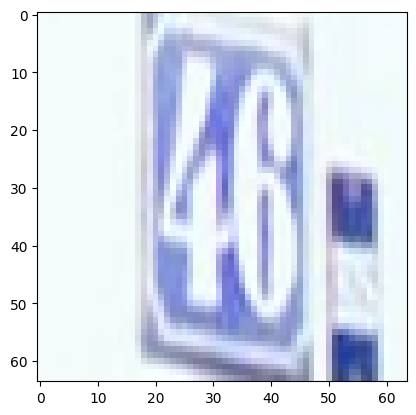

In [11]:
plt.imshow(image.permute(1, 2, 0))

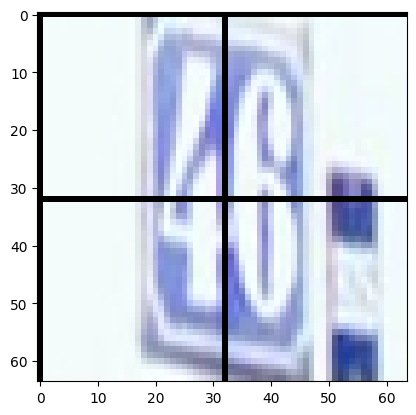

In [12]:
plt.imshow(draw_grid(image, grid_size=64//2))

In [13]:
pred = torch.zeros((1, 1 * (5 + 10), 2, 2))
pred.shape

torch.Size([1, 15, 2, 2])

In [14]:
pred[0, :5, 0, 0] = target[0, :5 , 0, 0]
pred[0, 4 + 5, 0, 0] = 0.95
pred[0, 5, 0, 0] = 0.9


pred[0, :5, 1, 1] = target[0, :5, 1, 1]
pred[0, 4 + 7, 1, 1] = 0.98
pred[0, 5, 1, 1] = 0.89



# pred[0, 8] = 0.9
# pred[0, 4, 0, 0] = 0.9
# pred[0, 15: 20, 0, 0] = target[0, :5, 0, 0]
# pred[0, 15, 0, 0] -= 0.1

# pred[0, 4, 0, 1] = 0.3

# pred[0, 15:20, 1, 1] = target[0, :5 , 1, 1]
# pred[0, 15:17, 1, 1] -= 0.53
# # pred[0, 15:19, 1, 1] -= 0.01
# pred[0, 25, 1, 1] = 0.9

In [19]:
pred[0, :, 0, 0], pred[0, :, 1, 1]

(tensor([-0.1875, -0.1744, -0.0189,  0.0834,  1.0000,  0.9000,  0.0000,  0.0000,
          0.0000,  0.9500,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]),
 tensor([ -2.1168, -18.4207,  -0.2908,   0.0834,   1.0000,   0.8900,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.9800,   0.0000,   0.0000,
           0.0000]))

In [44]:
criterion = YOLOLoss(num_classes=10, anchors=anchors)

In [45]:
pred.requires_grad = True

In [79]:
criterion(pred, bbox, labels, bbox_format=dataset.bbox_format)

target.shape: torch.Size([1, 2, 2, 6])
pred.shape torch.Size([1, 15, 2, 2])
obj_pred_xy.shape torch.Size([2, 1, 2]) obj_pred_wh.shape torch.Size([2, 1, 2])
tensor([[[4.5327e-01, 4.5652e-01]],

        [[1.0748e-01, 1.0000e-08]]], grad_fn=<IndexBackward0>) tensor([[[0.1963, 0.8696]],

        [[0.1495, 0.8696]]], grad_fn=<IndexBackward0>)
obj_target.shape torch.Size([2, 6]) obj_twh.shape torch.Size([2, 1, 2])
obj_pred_xywh.shape torch.Size([2, 4])


In [95]:
to_bbox_pred(pred, torch.zeros(5, 2), 10)

to bbox pred
torch.Size([5, 2, 2])
tensor([0, 0, 0, 0, 0])


In [274]:
non_maximum_suppression(pred)

tensor([[[[ -0.1875,   0.0000],
          [  0.0000,  -2.1168]],

         [[ -0.1744,   0.0000],
          [  0.0000, -18.4207]],

         [[ -0.0189,   0.0000],
          [  0.0000,  -0.2908]],

         [[  0.0834,   0.0000],
          [  0.0000,   0.0834]],

         [[  1.0000,   0.0000],
          [  0.0000,   1.0000]],

         [[  0.9000,   0.0000],
          [  0.0000,   0.8900]],

         [[  0.0000,   0.0000],
          [  0.0000,   0.0000]],

         [[  0.0000,   0.0000],
          [  0.0000,   0.0000]],

         [[  0.0000,   0.0000],
          [  0.0000,   0.0000]],

         [[  0.9500,   0.0000],
          [  0.0000,   0.0000]],

         [[  0.0000,   0.0000],
          [  0.0000,   0.0000]],

         [[  0.0000,   0.0000],
          [  0.0000,   0.9800]],

         [[  0.0000,   0.0000],
          [  0.0000,   0.0000]],

         [[  0.0000,   0.0000],
          [  0.0000,   0.0000]],

         [[  0.0000,   0.0000],
          [  0.0000,   0.0000]]]])
